# Гетерокседастичность и волатильность ряда

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_11/volatility.ipynb

**Оглавление**<a id='toc0_'></a>    
- [Загрузка данных](#toc1_)    
- [Исследование гетерокседастичности ряда](#toc2_)    
- [Создание признака волатильности и его исследование](#toc3_)    
- [Построение прогноза волатильности](#toc4_)    
  - [Построение прогноза для логарифмированных данных](#toc4_1_)    
  - [Построение прогноза для отложенной валидационной выборки](#toc4_2_)    
- [Результат](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Исследуем ряд на предмет гетерокседастичности и попробуем предсказать волатильность.

## <a id='toc1_'></a>[Загрузка данных](#toc0_)

In [ ]:
# Загрузим необходимые библиотеки и вспомогательные функции

import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

from utils.prepare_data import get_splitted_data
from utils.graphics import (
    display_corelogram, 
)
from utils.heplers import (
    display_mape, 
    check_time_series_stationarity,
)

%matplotlib inline 

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Загрузим данные
data = pd.read_csv(
    './data/retail_trade_and_food_services.csv',
    parse_dates=['per_name'],
    index_col='per_name',
)

data.head()

,val
per_name,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


## <a id='toc2_'></a>[Исследование гетерокседастичности ряда](#toc0_)

Разделим выборку на тренировочную, тестовую и валидационную.\
На тренировочной выборке будем исследовать ряд и обучать модель.\
Тестовую используем для поиска лучших параметров модели.\
А на валидационной посмотрим на результат предсказания.

In [3]:
train_data, test_data, valid_data = get_splitted_data(data)

Посмотрим на график ряда.

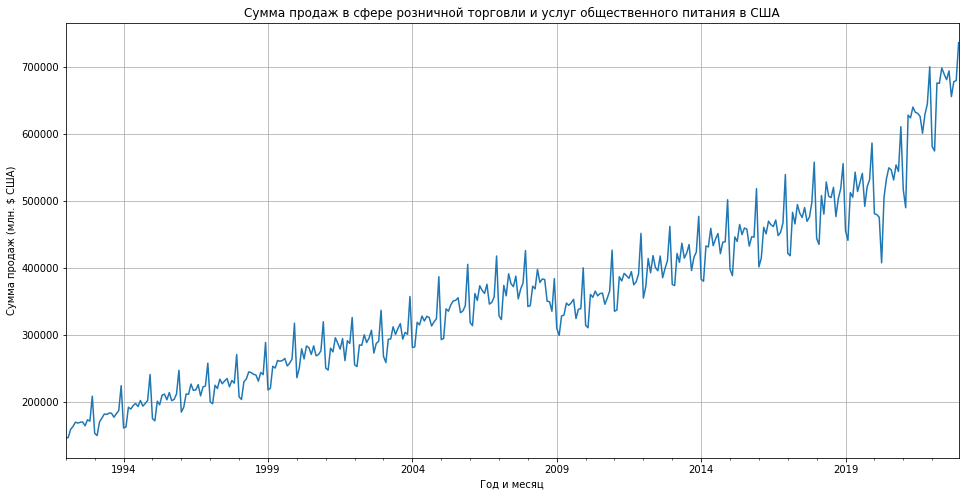

In [4]:
train_data.plot(
    figsize=(16, 8),
    title='Сумма продаж в сфере розничной торговли и услуг общественного питания в США',
    xlabel='Год и месяц',
    ylabel='Сумма продаж (млн. $ США)',
    grid=True,
    legend=False,
);

Видно, что разброс значений немного увеличивается со временем. \
То есть дисперсия данных изменчива во времени.

> **Дисперсия** — это статистический показатель, показывающий меру разброса данных вокруг среднего значения.

Формула расчета дисперсии:
$$ \sigma^2 = { \sum_{i=1}^{N} ( X_i - \mu )^2 \over N } $$

Формула расчета стандартного отклонения:
$$  \sigma = \sqrt{\sum_{i=1}^{N} ( X_i - \mu )^2 \over N}$$

Где
- $\mu$ - среднее по выборке
- $N$ - размер выборки
- $X_i$ - численное значение $i$-го наблюдения

Подобная неоднородность наблюдений, выражающаяся в неодинаковой дисперсии, называется **гетероскедастичностью**.

Такой характер дисперсии можно часто встретить во временных рядах из финансовой сферы, \
поскольку они более подвержены гетероскедастичности.

Отсутствие гетероскедастичности называется **гомоскедастичностью**.

Посмотрим на статистические показатели ряда в начале рассматриваемого периода.

In [5]:
train_data[:72][['val']].describe().T

,count,mean,std,min,25%,50%,75%,max
val,72.0,198305.347222,27253.042469,146376.0,176178.0,197951.0,218665.5,271054.0


И сравним их со значениями в конце периода.

In [6]:
train_data[-72:][['val']].describe().T

,count,mean,std,min,25%,50%,75%,max
val,72.0,548561.583333,81434.528892,407812.0,488303.25,528191.0,624647.25,736301.0


В конце периода стандартное отклонение больше.\
Посмотрим на изменение статистических показателей по годам.

In [7]:
train_stat_data = train_data.copy()
# Добавим признак года
train_stat_data['year'] = train_stat_data.index.year

# Сгруппируем статистические показатели по годам
describe_data = train_stat_data.groupby('year')['val'].describe()
describe_data.head()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1992,12.0,167841.833333,15772.334322,146376.0,162585.75,169276.5,170659.75,208838.0
1993,12.0,179424.583333,18579.635731,150087.0,174951.75,181883.0,183409.00,224540.0
1994,12.0,194186.250000,20122.145020,161349.0,191631.50,194440.5,199064.00,241111.0
1995,12.0,204219.000000,19253.081114,172138.0,199969.00,203727.5,211930.50,247491.0
1996,12.0,216982.833333,18318.398773,185019.0,211101.00,217811.0,224480.25,258081.0


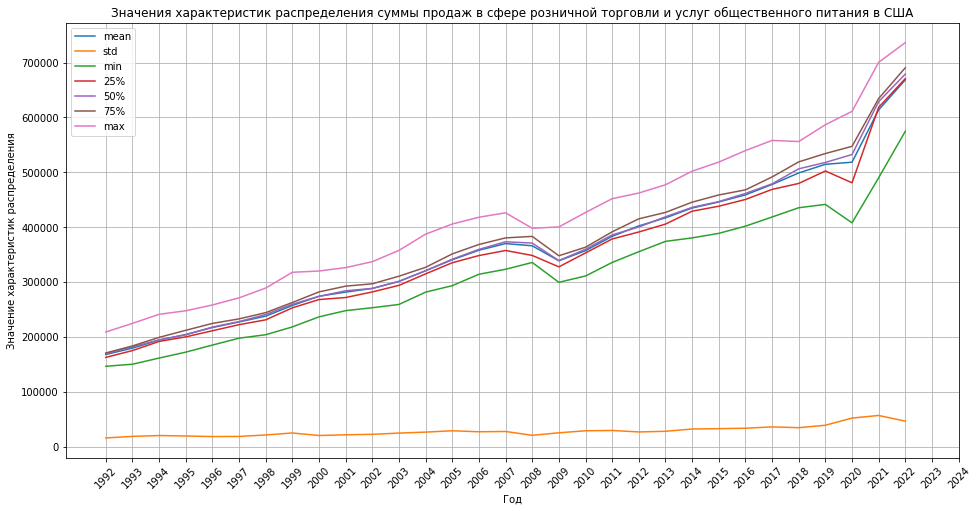

In [8]:
# Проследим изменение показателей на графике
describe_data[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot(
    figsize=(16, 8),
    xticks=list(range(1992, 2025)),
    xlabel='Год',
    ylabel='Значение характеристик распределения',
    title='Значения характеристик распределения суммы продаж \
в сфере розничной торговли и услуг общественного питания в США',
    grid=True,
    rot=45,
);

Стандартное отклонение медленно, но растет по годам.\
Растет также размах между минимальным и максимальным значениями.

## <a id='toc3_'></a>[Создание признака волатильности и его исследование](#toc0_)

> **Волатильность** представляет собой меру риска использования финансового инструмента за заданный промежуток времени. \
> Иными словами, волатильность показывает меру изменчивости и часто измеряется в процентах или долях. \
> Предсказание волатильности, например, позволяет инвесторам определить риск приобретения финансового инструмента.

Волатильность принято считать как разность текущего и предыдущего значения,\
деленное на предыдущее и умноженное на 100.\
Чтобы понять долю изменения значения.

Будем считать волатильность по формуле:

$$ Volatility(t) = |\frac{val(t) - val(t-1)}{val(t-1)} * 100| $$

In [9]:
data['val_volatility'] = data.val.pct_change().mul(100).abs()
data[['val_volatility']].head()

,val_volatility
per_name,
1992-01-01,NaN
1992-02-01,0.480270
1992-03-01,8.333617
1992-04-01,2.719411
1992-05-01,3.909720


Посмотрим, сколько у нас пропусков.

In [10]:
data.isna().sum()

val               0
val_volatility    1
dtype: int64

Для первого значения мы получили пропуск, т.к. у него нет предыдущего, которое можно было бы из него вычесть.\
Посмотрим, каким значением лучше заполнить этот пропуск.

In [11]:
# Добавим признак месяца
data['month'] = data.index.month

# Посмотрим на значения волатильности в январе в разные годы
data.loc[train_data.index][train_data.index.month == 1][['val_volatility']]

,val_volatility
per_name,
1992-01-01,NaN
1993-01-01,26.631647
1994-01-01,28.142425
1995-01-01,27.276649
1996-01-01,25.242130
1997-01-01,22.354222
1998-01-01,23.316756
1999-01-01,24.515779
2000-01-01,25.573650


Похоже, что значения плавно уменьшаются. Посмотрим на график.

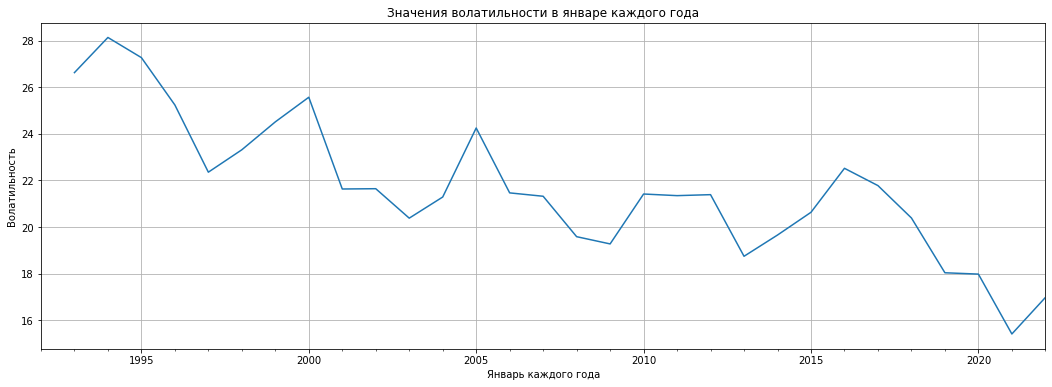

In [12]:
data.loc[train_data.index][train_data.index.month == 1]['val_volatility'].plot(
    figsize=(18, 6),
    title='Значения волатильности в январе каждого года',
    xlabel='Январь каждого года',
    ylabel='Волатильность',
    grid=True,
);

Значения имеют тендецию к уменьшению, поэтому заполнять первое пропущенное значение средним будет не верно.\
Заполним пропуск для 1992-01-01 значением из января следующего года.

In [13]:
# Извлечем значение для заполнения пропуска
fill_nan_value = data.loc['1993-01-01']['val_volatility']
# Заполним пропуск
data = data.fillna(fill_nan_value)
# Проверим результат
data.isna().sum()

val               0
val_volatility    0
month             0
dtype: int64

Снова разделим выборку, чтобы в нее попало значение волатильности.

In [14]:
train_volatility_data, test_volatility_data, valid_volatility_data = \
    get_splitted_data(data[['val_volatility']])

Отобразим полученную волатиьность на графике.

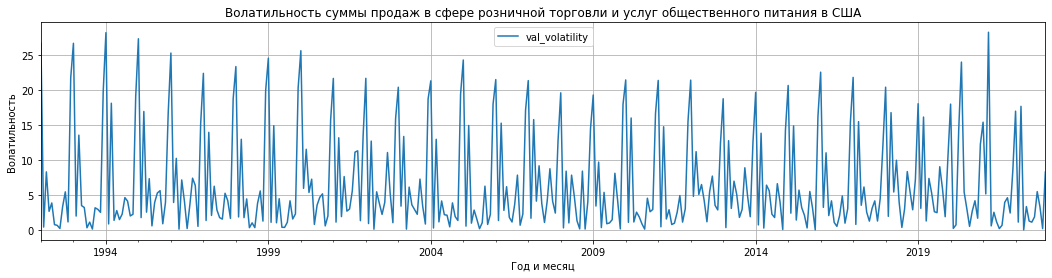

In [15]:
train_volatility_data.plot(
    figsize=(18, 4),    
    title='Волатильность суммы продаж в сфере розничной торговли и услуг общественного питания в США',
    xlabel='Год и месяц',
    ylabel='Волатильность',
    grid=True,
);

Изменения похожи на сезонные. Посмотрим на первые несколько значений отдельно.

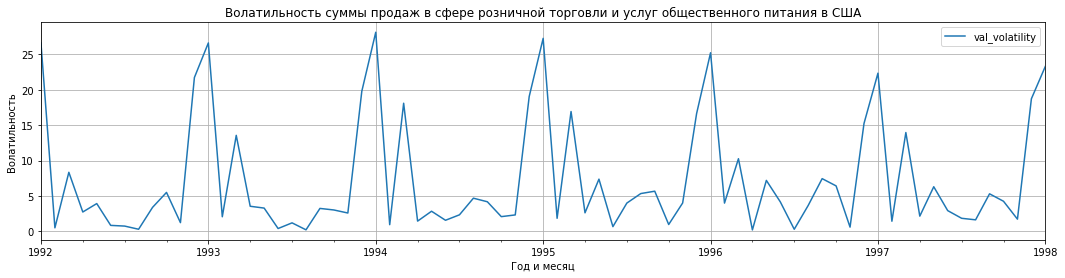

In [16]:
train_volatility_data[:73].plot(
    figsize=(18, 4),    
    title='Волатильность суммы продаж в сфере розничной торговли и услуг общественного питания в США',
    xlabel='Год и месяц',
    ylabel='Волатильность',
    grid=True,
);

У этих изменений явно есть сезонность в 12 месяцев.\
Посмотрим на последние значения.

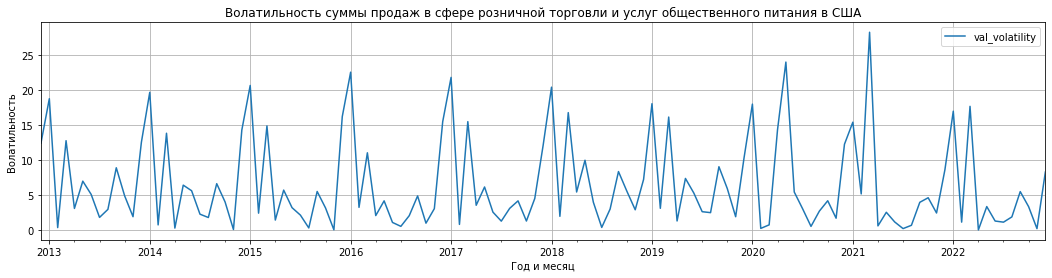

In [17]:
train_volatility_data[-121:].plot(
    figsize=(18,4),
    title='Волатильность суммы продаж в сфере розничной торговли и услуг общественного питания в США',
    xlabel='Год и месяц',
    ylabel='Волатильность',
    grid=True,
);

Здесь сезонность уже не такая выраженная, как для первых значений.

Посмотрим на распределение значений волатильности.

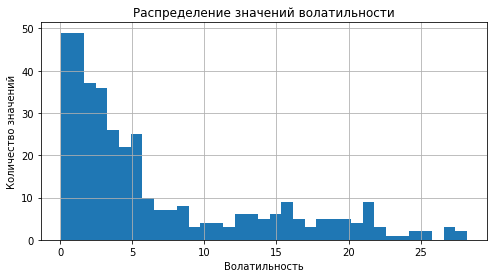

In [18]:
train_volatility_data.hist(
    figsize=(8, 4),
    bins=35,
)
plt.title('Распределение значений волатильности')
plt.xlabel('Волатильность')
plt.ylabel('Количество значений')

plt.show()

Распределение похоже на логнормальное, большинство значений близко к нулю.

## <a id='toc4_'></a>[Построение прогноза волатильности](#toc0_)

Попробуем предсказать волатильность.

In [19]:
# Посмотрим, стационарен ли тренировочный ряд с данными волатильности
check_time_series_stationarity(train_volatility_data)

Значение статистики теста: -3.5455005666799853
p-value: 0.006892606721281586
Критические значения разных уровней значимости:
    1%: -3.448748905151901
    5%: -2.8696473721448728
    10%: -2.5710891239349585
Значение статистики -3.5455005666799853 меньше выбранного уровня значимости 5%.
Отвергаем нулевую гипотезу, РЯД СТАЦИОНАРНЫЙ.


Ряд стационарен, можем построить для него корелограмму.

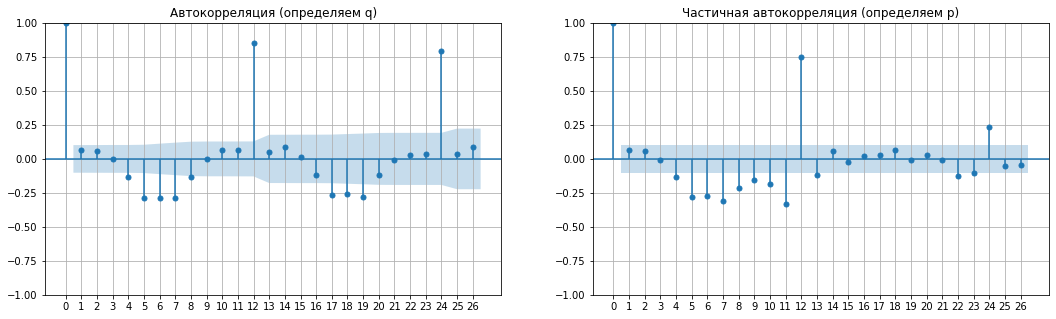

In [20]:
# Строим корелограмму
display_corelogram(train_volatility_data)

На обоих графиках выделяется 12-й лаг.\
Для предсказания используем [GARCH](https://arch.readthedocs.io/en/latest/univariate/introduction.html) модель.\
Найдем подходящие параметры с помощью перебора.

In [21]:
# Словарь с параметрами и метриками, который будем заполнять
param_results = {
    'p': [], # Параметр модели p
    'q': [], # Параметр модели q
    'aic': [], # Значение AIC (Акаика) для параметров p и q
    'mape_in_percent': [], # Значение MAPE в % для параметров p и q
}

# Будем перебирать значения p и q в диапазоне от 1 до 12
for p in range (1, 13):
    for q in range(1, 13):
        # При определенных значениях параметров обучение модели может вылететь в ошибку,
        # поэтому используем конструкцию try except
        try:
            # Создаем объект модели
            model = arch_model(
                pd.concat([train_volatility_data, test_volatility_data]), 
                p=p, 
                q=q, 
                vol='GARCH'
            )
            # Обучаем модель
            model_fitted = model.fit(
                # Дата, до которой берется обучающая выборка
                last_obs=test_volatility_data.index[0], 
                # Параметры для скрытия вывода процесса обучения модели
                update_freq=0, 
                disp=False
            )
            # Делаем предсказание для дат тестовой выборки
            prediction = model_fitted.forecast().residual_variance.loc[
                test_volatility_data.index
            ]
            # Считаем метрику MAPE
            mape_in_percent = mean_absolute_percentage_error(
                test_volatility_data, prediction
            )*100
            # Заносим результаты в словарь
            param_results['p'].append(p)
            param_results['q'].append(q)
            param_results['aic'].append(model_fitted.aic)
            param_results['mape_in_percent'].append(mape_in_percent)
        except:
            print(f'Incorrect params: p={p}, q={q}')

c:\Users\exper\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [22]:
# Преобразуем словарь в таблицу
param_results_data = pd.DataFrame(param_results)

# Отсортируем результаты по Акаике
print('Сортировка по AIC')
display(param_results_data.sort_values(by='aic').head())

print('Сортировка по MAPE')
# Отсортируем результаты по MAPE
display(param_results_data.sort_values(by='mape_in_percent').head())

Сортировка по AIC


,p,q,aic,mape_in_percent
143,12,12,2119.278231,1169.197134
133,12,2,2135.478002,881.322549
134,12,3,2137.456091,882.143566
135,12,4,2139.456090,882.090996
136,12,5,2141.456090,882.113209


Сортировка по MAPE


,p,q,aic,mape_in_percent
9,1,10,2358.330403,465.222452
69,6,10,2363.800011,506.763018
105,9,10,2369.800016,506.767878
45,4,10,2359.800007,506.791592
21,2,10,2355.800025,506.792766


Будем ориентироваться на  результат метрики `MAPE` и возьмем `p=1` и `q=10`.

In [23]:
# Создаем объект модели
garch_model = arch_model(
    pd.concat([train_volatility_data, test_volatility_data]), 
    p=1, 
    q=10, 
    vol='GARCH'
)

# Обучаем модель
garch_model_fitted = garch_model.fit(
    # Указываем последний объект, до которого будем совершать обучение
    last_obs=test_volatility_data.index[0], 
    # Как часто будет отправляться отчет
    update_freq=5,
)

garch_model_fitted.summary()

Iteration:      5,   Func. Count:     76,   Neg. LLF: 1216.9147087128767
Iteration:     10,   Func. Count:    149,   Neg. LLF: 1182.735667443996
Iteration:     15,   Func. Count:    221,   Neg. LLF: 1166.1800233410677
Iteration:     20,   Func. Count:    297,   Neg. LLF: 1166.165328214444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1166.1652016595908
            Iterations: 24
            Function evaluations: 328
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         val_volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1166.17
Distribution:                  Normal   AIC:                           2358.33
Method:            Maximum Likelihood   BIC:                           2409.28
                                        No. Observations:                  372
Date:                Sun, Apr 06 2025   Df Residuals:                      371
Time:                        15:16:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.8704      4.076      0.949      0.342 [ -4.119, 11.860]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega      4.7754e-07     42.634  1.120e-08      1.000    [-83.561, 83.561]
alpha[1]       0.5852      0.666      0.879      0.379    [ -0.720,  1.890]
beta[1]        0.2179      0.594      0.367      0.714    [ -0.947,  1.383]
beta[2]    1.0943e-08      1.030  1.062e-08      1.000    [ -2.020,  2.020]
beta[3]    2.0437e-08      0.457  4.477e-08      1.000    [ -0.895,  0.895]
beta[4]    2.8935e-08      0.196  1.479e-07      1.000    [ -0.384,  0.384]
beta[5]    2.6234e-08      0.247  1.061e-07      1.000    [ -0.485,  0.485]
beta[6]    3.9658e-08      0.101  3.933e-07      1.000    [ -0.198,  0.198]
beta[7]    2.6166e-08      0.718  3.647e-08      1.000    [ -1.406,  1.406]
beta[8]    2.6945e-08      0.124  2.175e-07      1.000    [ -0.243,  0.243]
beta[9]    5.0499e-09      0.253  1.995e-08      1.000    [ -0.496,  0.496]
beta[10]       0.1968      0.136      1.447      0.148 [-6.974e-02,  0.463]
===========================================================================

Covariance estimator: robust
"""

Теперь получим прогноз и посчитаем метрику `MAPE`.

In [24]:
# Получаем предсказание
predictions = garch_model_fitted.forecast().residual_variance.loc[
    test_volatility_data.index
]

# Посчитаем MAPE для нашего предсказания
display_mape(test_volatility_data, predictions)

Метрика MAPE: 465.22 %


Значение больше, чем 100%.\
Посмотрим, как результат выглядит на графике.

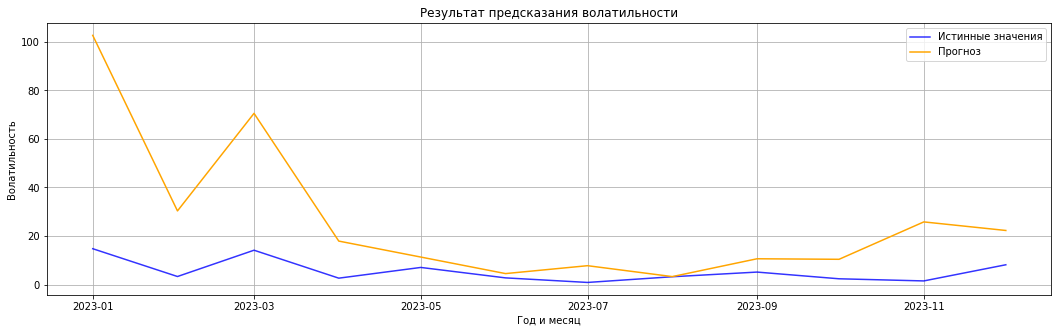

In [25]:
# В таблицу result_data соберем данные 
# для графика с тестовыми и предсказанными значениями
result_data = test_volatility_data.copy()
result_data['predictions'] = predictions

# Выведем график
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(result_data['val_volatility'], color='blue', alpha=0.8, label='Истинные значения')
ax.plot(result_data['predictions'], color='orange', label='Прогноз')
ax.set_title('Результат предсказания волатильности')
ax.set_xlabel('Год и месяц')
ax.set_ylabel('Волатильность')
ax.grid()
ax.legend()

plt.show()

Посмотрим на диапазон предсказанных и тренировочных значений.

In [26]:
print('Характеристики распределения значений тренировочной выборки')
display(train_volatility_data.describe().T)

print('Характеристики распределения значений предсказания')
display(predictions.describe().T)

Характеристики распределения значений тренировочной выборки


,count,mean,std,min,25%,50%,75%,max
val_volatility,372.0,6.643199,6.918334,0.075281,1.543766,3.839026,9.329212,28.20179


Характеристики распределения значений предсказания


,count,mean,std,min,25%,50%,75%,max
h.1,12.0,26.449282,30.09804,3.268785,9.737645,14.610561,26.936583,102.672866


Модель предсказала скачки со значениями, которых не было в тренировочной выборки (значение `max` из таблиц выше).

Попробуем логарифмировать данные и сделать по ним предсказание.\
Возможно, это улучшит результат.

### <a id='toc4_1_'></a>[Построение прогноза для логарифмированных данных](#toc0_)

In [ ]:
# Добавим признак с логарифмированными значениями волатильности
data['val_volatility_log'] = np.log(data['val_volatility'])

data.head()

,val,val_volatility,month,val_volatility_log
per_name,,,,
1992-01-01,146376.0,26.631647,1,3.282100
1992-02-01,147079.0,0.480270,2,-0.733407
1992-03-01,159336.0,8.333617,3,2.120298
1992-04-01,163669.0,2.719411,4,1.000415
1992-05-01,170068.0,3.909720,5,1.363466


И создадим функцию, которая будет приводить значение к исходному.\
Позже применим ее к результатам предсказания.

In [34]:
def get_source_value(log_value: float) -> float:
    return np.exp(log_value)

Разделим выборку на тренировочную, тестовую и валидационную для логарифмированного значения.

In [ ]:
train_volatility_log_data, test_volatility_log_data, valid_volatility_log_data = \
    get_splitted_data(data[['val_volatility_log']])

Посмотрим, как выглядят логарифмированные значения на графике.

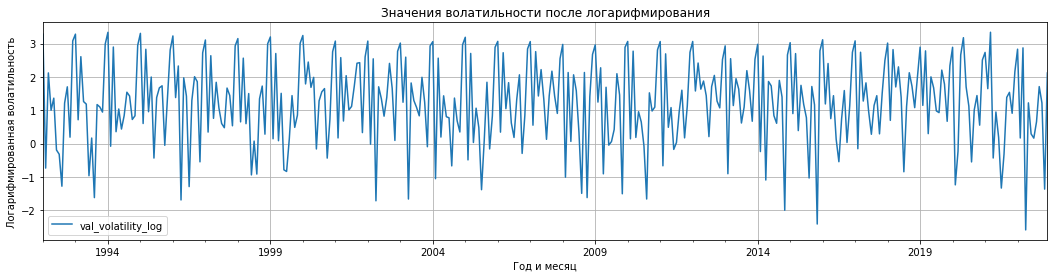

In [30]:
train_volatility_log_data.plot(
    figsize=(18, 4),    
    title='Значения волатильности после логарифмирования',
    xlabel='Год и месяц',
    ylabel='Логарифмированная волатильность',
    grid=True,
);

Распределение похоже на стационарный ряд.\
Посмотрим также на распределение значений после логарифмирования.

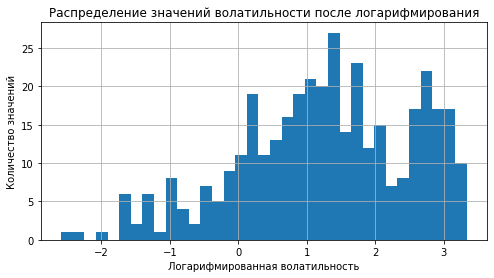

In [31]:
train_volatility_log_data.hist(
    figsize=(8, 4),
    bins=35,
)
plt.title('Распределение значений волатильности после логарифмирования')
plt.xlabel('Логарифмированная волатильность')
plt.ylabel('Количество значений')

plt.show()

Вид распределение больше похоже на нормальное.\
Но оно немного скошено вправо и имеет два "горба".

In [32]:
# Посмотрим, стационарен ли тренировочный ряд с данными волатильности
check_time_series_stationarity(train_volatility_log_data)

Значение статистики теста: -3.590228545663323
p-value: 0.0059506083938202885
Критические значения разных уровней значимости:
    1%: -3.448645946352023
    5%: -2.869602139060357
    10%: -2.5710650077160495
Значение статистики -3.590228545663323 меньше выбранного уровня значимости 5%.
Отвергаем нулевую гипотезу, РЯД СТАЦИОНАРНЫЙ.


Ряд стационарен, мы можем построить для него корелограмму.

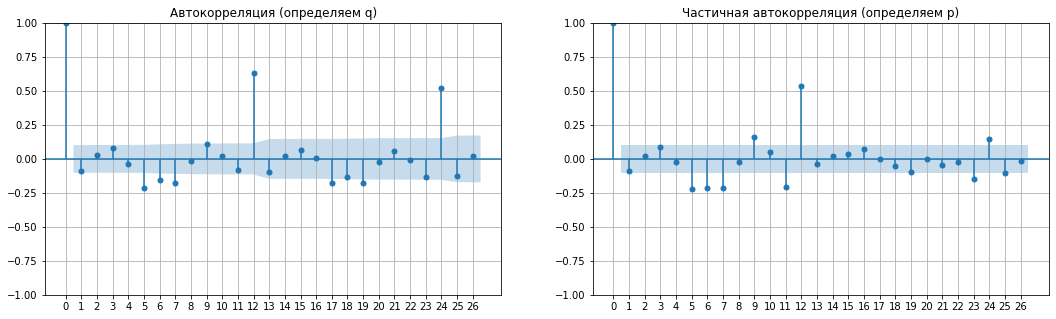

In [33]:
display_corelogram(train_volatility_log_data)

И снова наиболее сильно выделяются 12-е лаги на обоих графиках.\
Используем модель GARCH для предсказания и определим лучшие параметры с помощью перебора.

In [35]:
# Словарь с параметрами и метриками, который будем заполнять
param_results = {
    'p': [], # Параметр модели p
    'q': [], # Параметр модели q
    'aic': [], # Значение AIC (Акаика) для параметров p и q
    'mape_in_percent': [], # Значение MAPE в % для параметров p и q
}

# Будем перебирать значения p и q в диапазоне от 1 до 12
for p in range (1, 13):
    for q in range(1, 13):
        # При определенных значениях параметров обучение модели может вылететь в ошибку,
        # поэтому используем конструкцию try except
        try:
            # Создаем объект модели
            model = arch_model(
                pd.concat([train_volatility_log_data, test_volatility_log_data]), 
                p=p, 
                q=q, 
                vol='GARCH'
            )
            # Обучаем модель
            model_fitted = model.fit(
                # Дата, до которой берется обучающая выборка
                last_obs=test_volatility_log_data.index[0], 
                # Параметры для скрытия вывода процесса обучения модели
                update_freq=0, 
                disp=False
            )
            # Делаем предсказание для дат тестовой выборки
            prediction = model_fitted.forecast().residual_variance.loc[
                test_volatility_log_data.index
            ]
            # Считаем метрику MAPE
            mape_in_percent = mean_absolute_percentage_error(
                # Исходные значения волатильности
                data.loc[test_volatility_log_data.index]['val_volatility'], 
                # Предсказание восстанавливаем из логарифмического масштаба в исходный
                get_source_value(prediction)
            )*100
            # Заносим результаты в словарь
            param_results['p'].append(p)
            param_results['q'].append(q)
            param_results['aic'].append(model_fitted.aic)
            param_results['mape_in_percent'].append(mape_in_percent)
        except:
            print(f'Incorrect params: p={p}, q={q}')

In [36]:
# Преобразуем словарь в таблицу
param_results_data = pd.DataFrame(param_results)

# Отсортируем результаты по Акаике
print('Сортировка по AIC')
display(param_results_data.sort_values(by='aic').head())

# Отсортируем результаты по MAPE
print('Сортировка по MAPE')
display(param_results_data.sort_values(by='mape_in_percent').head())

Сортировка по AIC


,p,q,aic,mape_in_percent
132,12,1,1225.613961,670.890655
133,12,2,1227.613961,670.787933
134,12,3,1229.613961,670.781144
135,12,4,1231.613961,670.720773
0,1,1,1232.182993,101.926507


Сортировка по MAPE


,p,q,aic,mape_in_percent
47,4,12,1257.546911,72.987463
46,4,11,1255.974627,75.098116
45,4,10,1253.974563,75.123227
44,4,9,1251.974563,75.124603
32,3,9,1249.974563,75.125065


Будем ориентироваться на  результат метрики `MAPE` и возьмем `p=4` и `q=12`.

In [37]:
garch_model = arch_model(
    pd.concat([train_volatility_log_data, test_volatility_log_data]), 
    p=4, 
    q=12, 
    vol='GARCH'
)

garch_model_fitted = garch_model.fit(
    # Указываем последний объект, до которого будем совершать обучение
    last_obs=test_volatility_log_data.index[0], 
    # Как часто будет отправляться отчет
    update_freq=5,
)

garch_model_fitted.summary()

Iteration:      5,   Func. Count:    102,   Neg. LLF: 612.0742647201942
Iteration:     10,   Func. Count:    200,   Neg. LLF: 619.2506881254992
Iteration:     15,   Func. Count:    300,   Neg. LLF: 610.8053563553561
Iteration:     20,   Func. Count:    402,   Neg. LLF: 615.8543836565458
Iteration:     25,   Func. Count:    506,   Neg. LLF: 610.7753148843269
Optimization terminated successfully    (Exit mode 0)
            Current function value: 610.7734553549594
            Iterations: 28
            Function evaluations: 545
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:     val_volatility_log   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -610.773
Distribution:                  Normal   AIC:                           1257.55
Method:            Maximum Likelihood   BIC:                           1328.09
                                        No. Observations:                  372
Date:                Sun, Apr 06 2025   Df Residuals:                      371
Time:                        15:44:05   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2526  8.951e-02     13.994  1.686e-44 [  1.077,  1.428]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0875      0.114      0.770      0.441      [ -0.135,  0.310]
alpha[1]   1.0407e-03      0.164  6.359e-03      0.995      [ -0.320,  0.322]
alpha[2]   4.1202e-12  4.907e-02  8.396e-11      1.000 [-9.618e-02,9.618e-02]
alpha[3]       0.0787  4.493e-02      1.751  7.994e-02   [-9.386e-03,  0.167]
alpha[4]   3.2243e-12      0.109  2.971e-11      1.000      [ -0.213,  0.213]
beta[1]    5.8017e-13      0.831  6.979e-13      1.000      [ -1.629,  1.629]
beta[2]    1.6289e-12      0.202  8.055e-12      1.000      [ -0.396,  0.396]
beta[3]    2.4693e-13      0.412  5.990e-13      1.000      [ -0.808,  0.808]
beta[4]        0.0175      0.138      0.126      0.900      [ -0.254,  0.289]
beta[5]    1.6918e-12      0.165  1.027e-11      1.000      [ -0.323,  0.323]
beta[6]    8.6446e-13      0.164  5.279e-12      1.000      [ -0.321,  0.321]
beta[7]    2.3469e-13      0.154  1.528e-12      1.000      [ -0.301,  0.301]
beta[8]    2.2622e-12      0.281  8.064e-12      1.000      [ -0.550,  0.550]
beta[9]        0.7076      0.104      6.781  1.195e-11      [  0.503,  0.912]
beta[10]   3.7690e-13      0.938  4.019e-13      1.000      [ -1.838,  1.838]
beta[11]   1.3748e-12      0.221  6.223e-12      1.000      [ -0.433,  0.433]
beta[12]       0.1366      0.538      0.254      0.799      [ -0.918,  1.191]
=============================================================================

Covariance estimator: robust
"""

In [38]:
# Делаем предсказание
predictions = garch_model_fitted.forecast().residual_variance.loc[
    test_volatility_log_data.index
]
# Переведем предсказание логарифмированных значений в исходный масштаб
predictions_exp = get_source_value(predictions)

# Посчитаем MAPE для нашего предсказания
display_mape(
    data.loc[test_volatility_log_data.index]['val_volatility'], 
    predictions_exp
)

Метрика MAPE: 72.99 %


73% это лучше, чем предыдущие 465%.\
Посмотрим, как результат предсказания выглядит на графике.

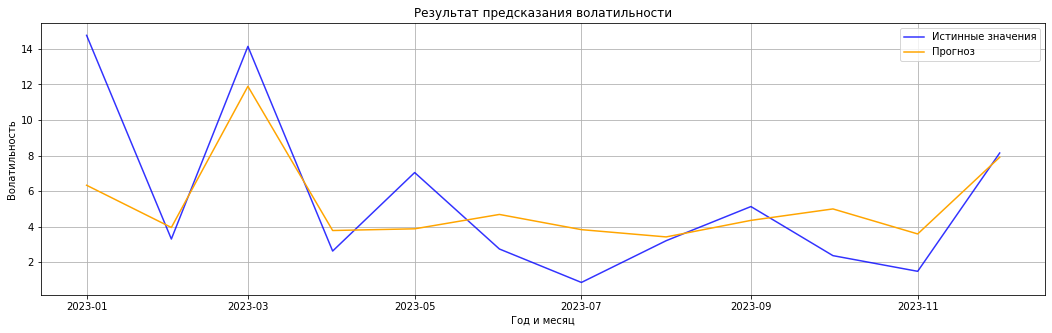

In [39]:
# В таблицу result_data соберем данные 
# для графика с тестовыми и предсказанными значениями

# Истинные значения волатильности
result_data = data.loc[test_volatility_log_data.index][['val_volatility']]
# Предсказанные значения, переведенные в исходный масштаб
result_data['predictions_exp'] = predictions_exp

# Выведем график
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(result_data['val_volatility'], color='blue', alpha=0.8, label='Истинные значения')
ax.plot(result_data['predictions_exp'], color='orange', label='Прогноз')
ax.set_title('Результат предсказания волатильности')
ax.set_xlabel('Год и месяц')
ax.set_ylabel('Волатильность')
ax.grid()
ax.legend()

plt.show()

Модель не уловила первый пик для января, но в целом график выглядит лучше, чем предыдущий.

Посмотрим, какой будет результат на отложенной выборке.

### <a id='toc4_2_'></a>[Построение прогноза для отложенной валидационной выборки](#toc0_)

In [40]:
garch_model = arch_model(
    pd.concat([train_volatility_log_data, test_volatility_log_data, valid_volatility_log_data]), 
    p=4, 
    q=12, 
    vol='GARCH'
)

garch_model_fitted = garch_model.fit(
    # Указываем последний объект, до которого будем совершать обучение
    last_obs=valid_volatility_log_data.index[0], 
    # Как часто будет отправляться отчет
    update_freq=5,
)

garch_model_fitted.summary()

Iteration:      5,   Func. Count:    102,   Neg. LLF: 628.4462205055812
Iteration:     10,   Func. Count:    198,   Neg. LLF: 627.8768640289129
Iteration:     15,   Func. Count:    298,   Neg. LLF: 627.6260199995131
Iteration:     20,   Func. Count:    397,   Neg. LLF: 627.0489859277839
Iteration:     25,   Func. Count:    493,   Neg. LLF: 627.0459876874083
Iteration:     30,   Func. Count:    587,   Neg. LLF: 627.0458375564049
Optimization terminated successfully    (Exit mode 0)
            Current function value: 627.0458375564974
            Iterations: 30
            Function evaluations: 587
            Gradient evaluations: 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:     val_volatility_log   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -627.046
Distribution:                  Normal   AIC:                           1290.09
Method:            Maximum Likelihood   BIC:                           1361.20
                                        No. Observations:                  384
Date:                Sun, Apr 06 2025   Df Residuals:                      383
Time:                        15:54:21   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2693  8.339e-02     15.220  2.601e-52 [  1.106,  1.433]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.8145e-03      0.152  5.144e-02      0.959      [ -0.290,  0.306]
alpha[1]   2.5891e-06  5.214e-02  4.966e-05      1.000      [ -0.102,  0.102]
alpha[2]   2.8742e-10  1.889e-02  1.521e-08      1.000 [-3.703e-02,3.703e-02]
alpha[3]       0.0651  2.462e-02      2.646  8.156e-03    [1.688e-02,  0.113]
alpha[4]       0.0000  6.556e-02      0.000      1.000      [ -0.129,  0.129]
beta[1]        0.0000      0.528      0.000      1.000      [ -1.035,  1.035]
beta[2]        0.0000      0.185      0.000      1.000      [ -0.362,  0.362]
beta[3]        0.0000      0.309      0.000      1.000      [ -0.605,  0.605]
beta[4]        0.0214      0.109      0.195      0.845      [ -0.193,  0.236]
beta[5]        0.0000  9.261e-02      0.000      1.000      [ -0.182,  0.182]
beta[6]        0.0000      0.133      0.000      1.000      [ -0.262,  0.262]
beta[7]        0.0000  9.389e-02      0.000      1.000      [ -0.184,  0.184]
beta[8]        0.0000      0.159      0.000      1.000      [ -0.311,  0.311]
beta[9]        0.7297      0.117      6.213  5.207e-10      [  0.500,  0.960]
beta[10]   7.5748e-08      0.504  1.503e-07      1.000      [ -0.988,  0.988]
beta[11]       0.0000      0.198      0.000      1.000      [ -0.387,  0.387]
beta[12]       0.1728      0.358      0.483      0.629      [ -0.528,  0.874]
=============================================================================

Covariance estimator: robust
"""

In [41]:
# Делаем предсказание
predictions = garch_model_fitted.forecast().residual_variance.loc[
    valid_volatility_log_data.index
]
# Переведем предсказание логарифмированных значений в исходный масштаб
predictions_exp = get_source_value(predictions)

# Посчитаем MAPE для нашего предсказания
display_mape(
    data.loc[valid_volatility_log_data.index]['val_volatility'], 
    predictions_exp
)

Метрика MAPE: 103.85 %


Посмотрим, как результат предсказания выглядит на графике.

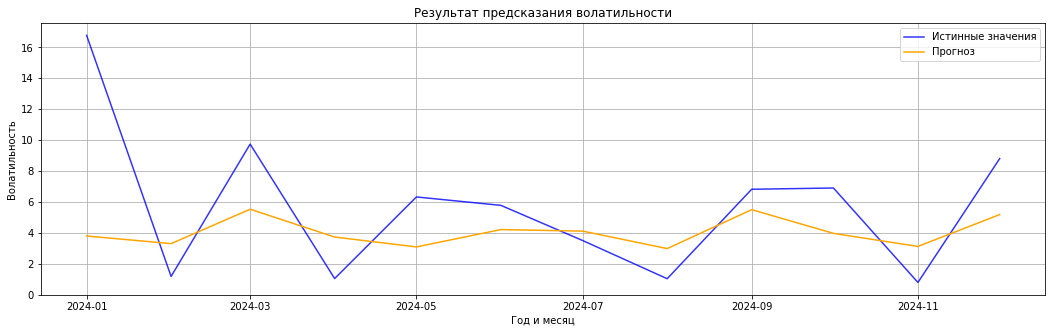

In [42]:
# В таблицу result_data соберем данные 
# для графика с тестовыми и предсказанными значениями

# Истинные значения волатильности
result_data = data.loc[valid_volatility_log_data.index][['val_volatility']]
# Предсказанные значения, переведенные в исходный масштаб
result_data['predictions_exp'] = predictions_exp

# Выведем график
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(result_data['val_volatility'], color='blue', alpha=0.8, label='Истинные значения')
ax.plot(result_data['predictions_exp'], color='orange', label='Прогноз')
ax.set_title('Результат предсказания волатильности')
ax.set_xlabel('Год и месяц')
ax.set_ylabel('Волатильность')
ax.grid()
ax.legend()

plt.show()

Как и в случае с тестовой выборкой модель не уловила первый пик для значения в январе.\
Но в целом предсказание повторяет график для истинных значений, что неплохо.

## <a id='toc5_'></a>[Результат](#toc0_)

Рассматриваемый ряд судя по графику обладает гетерокседастичностью (разброс значений увеличивается со временем).

Для предсказания волатильности с помощью модели GARCH мы получили более лучший результат на логарифмированных значениях.

На тестовой выборке метрика MAPE составила 72.99 %\
А на отложенной валидационной при тех же параметрах модели 103.85 %

Графики предсказанных значений примерно повторяют график для истинных значений.\
Что говорит о том, что модель GARCH в целом уловила тенденцию.